**analysis.ipynb**

**Description:** Interactive auxillary support for my summer internship repport. This is the analysis of three recurrent neural networks using mainly primary component analysis (PCA) and slow point analysis.

**Author:** Aude Forcione-lambert, University of Montreal, Faculty of Arts and Sciences

**Email:** aude.forcione-lambert@umontreal.ca

# Importations

In [1]:
import numpy as np
import scipy
from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Uncomment for interactive graphics. Be aware that this will slow down the program.
#%matplotlib notebook

# Useful variables

In [3]:
# Number of neurons
nb_neurons = 100
# Identity matrix matching the main matrix's size
I = np.diag(np.ones(nb_neurons))
# Possible switches by index
# Possible outputs are either represented by tensions (3 channels of real numbers roughly between -1 and 1) or by an
# index between 0 and 8. Index and tension of each three channels are related by the binary representation of the
# index. The unit digit corresponds to channel one, a 0 digit corresponds to a tension of -1 and a 1 to a tension of 1.
switch = np.array([[0,1],[0,2],[0,4],[1,3],[1,5],[2,3],[2,6],[3,7],[4,5],[4,6],[5,7],[6,7]])
# Colors used in graphics for each index
colors = ('indianred','darkorange','gold','lime','turquoise','royalblue','blueviolet','magenta')

# Useful functions

In [4]:
# Converts channel tensions to the corresponding index... Honestly it's pretty self-explanatory............................. Do I really have to do this everywhere? I'm not using three meters long variable names for fun.............................................................. Fine, I'll do it. This is for you, all my past programming teachers........................ Shoutout to Sonia Gounar, you are one great teacher, even if you did always remove some of my points for non-sufficient comments... I might have deserved it.............................................................................................................................................................................................................................I need coffee
def tension_to_index(tension):
    tension = np.round(tension)
    return int((tension[0]+1)/2+(tension[1]+1)+2*(tension[2]+1))

# Same but the other way around
def index_to_tension(index):
    tension = np.zeros((3))
    tension[0] = (index%2)*2-1
    # These >> are bitshifts. Bitshifts are cool
    tension[1] = ((index >> 1)%2)*2-1
    tension[2] = ((index >> 2)%2)*2-1
    return tension

# Calculates next network state in the absence of input. Useful for q function
def F(state,w):
    return np.tanh(np.matmul(state,w))

# Energy function used for finding slow points
def q(state,w):
    return 1/2.0*np.linalg.norm(F(state,w)-state)**2

# Find all instances of a short pattern in a long array
def matchPattern(base_array,pattern):
    indexes = []
    for i in range(len(base_array)-len(pattern)):
        if np.all(base_array[i:i+len(pattern)] == pattern):
            indexes.append(i)
    return np.array(indexes)

# Data importation

In [5]:
# Input array  (3 channels)
x_test_array = np.loadtxt('Data/x_test_array.gz')
# Expected output array (3 channels)
y_test_array = np.loadtxt('Data/y_test_array.gz')

# Loss over time for random_seed = 7 and time_delay = 0
#s7d0_loss = np.loadtxt('Data/s7d0_loss.gz')
# Output during testing
s7d0_output = np.loadtxt('Data/s7d0_output.gz')
# States of neurons during testing
s7d0_states = np.loadtxt('Data/s7d0_states.gz')
# W matrix (or strengths of neurons connections)
s7d0_w = np.loadtxt('Data/s7d0_w.gz')
# Wout matrix
#s7d0_wout = np.loadtxt('Data/s7d0_wout.gz')

# Same for random_seed = 7 and time_delay = 4
s7d4_loss = np.loadtxt('Data/s7d4_loss.gz')
s7d4_output = np.loadtxt('Data/s7d4_output.gz')
s7d4_states = np.loadtxt('Data/s7d4_states.gz')
s7d4_w = np.loadtxt('Data/s7d4_w.gz')
#s7d4_wout = np.loadtxt('Data/s7d4_wout.gz')

# Same for random_seed = 7 and time_delay = 8
#s7d8_loss = np.loadtxt('Data/s7d8_loss.gz')
s7d8_output = np.loadtxt('Data/s7d8_output.gz')
s7d8_states = np.loadtxt('Data/s7d8_states.gz')
s7d8_w = np.loadtxt('Data/s7d8_w.gz')
#s7d8_wout = np.loadtxt('Data/s7d8_wout.gz')

# Win matrix for random_seed = 7 and all time delays
#s7_win = np.loadtxt('Data/s7_win.gz')

# Task Definition

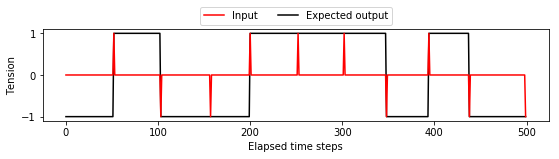

In [6]:
fig,(ax) = plt.subplots(1,1,sharex=True,figsize=(8,2.5))
# Expected output
ax.plot(y_test_array[:500,0],'k')
# Input
ax.plot(x_test_array[:500,0],'r')

ax.set_ylabel('Tension')
ax.set_xlabel('Elapsed time steps')
custom_legend = [Line2D([0], [0], color='r', label='Input'),
                Line2D([0], [0], color='k', label='Expected output')]
ax.legend(handles=custom_legend, loc='upper center', bbox_to_anchor=(.5,1.3), ncol=2)

fig.tight_layout()

---
Basic definition of the task. The neural network is expected to match and maintain the last input of one or minus one.

---

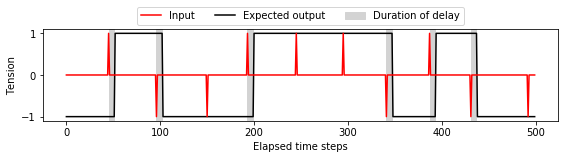

In [8]:
fig,(ax) = plt.subplots(1,1,sharex=True,figsize=(8,2.5))
# Setting delay for the demonstration's purpose
delay = 7
# Expected output
ax.plot(y_test_array[:500,0],'k')
# Input
ax.plot(x_test_array[delay:500+delay,0],'r')
# Visualisation of delay
ax.set_yticks([-1,0,1])
for i in np.where(np.abs(np.round((y_test_array[0:499,0]-x_test_array[1:500,0])))==2)[0] :
    ax.axvspan(i-delay+1,i,color='lightgray')

ax.set_ylabel('Tension')
ax.set_xlabel('Elapsed time steps')
custom_legend = [Line2D([0], [0], color='r', label='Input'),
                Line2D([0], [0], color='k', label='Expected output'),
                mpl.patches.Patch(facecolor='lightgray', edgecolor='lightgray', label='Duration of delay')]
ax.legend(handles=custom_legend, loc='upper center', bbox_to_anchor=(.5,1.3), ncol=3)

fig.tight_layout()

---
New task definition. Now the neural network must lag (and therefore remember) during a certain number of time steps after the input.

---

# Training

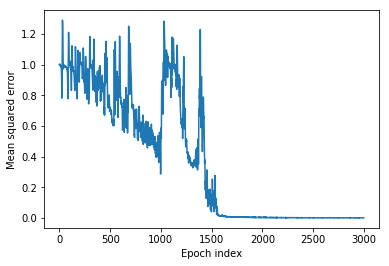

In [9]:
plt.figure()
plt.subplot(1,1,1)
plt.xlabel("Epoch index")
plt.ylabel("Mean squared error")
plt.plot(np.arange(3000),s7d4_loss[:3000])

---
Sample loss over training epoch. This graphic was generated during training of the RNN with a random seed of 7 and a delay of 4 time steps.

---

# Elementary case

In [10]:
# Simple pca analysis of the test for random_seed=7 and time_delay=0

s7d0_pca = PCA(n_components=3)
s7d0_pca.fit(s7d0_states)
s7d0_pc1, s7d0_pc2, s7d0_pc3 = s7d0_pca.transform(s7d0_states).T

# Type of output for the neurons states
s7d0_out_type = np.array([tension_to_index(out) for out in s7d0_output])

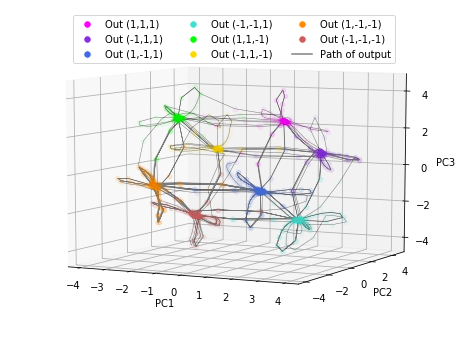

In [11]:
# Drawing of pca analysis

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

#
for i in range(3000):
    ax.scatter(s7d0_pc1[i], s7d0_pc2[i], s7d0_pc3[i], c=colors[s7d0_out_type[i]], alpha=0.05)

ax.plot(s7d0_pc1[:3000], s7d0_pc2[:3000], s7d0_pc3[:3000], '-k', linewidth=0.5, alpha=0.5)

custom_legend = [
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,1])], marker = '.', label = 'Out (1,1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,1,1])], marker = '.', label = 'Out (-1,1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,-1,1])], marker = '.', label = 'Out (1,-1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,-1,1])], marker = '.', label = 'Out (-1,-1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,-1])], marker = '.', label = 'Out (1,1,-1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,1,-1])], marker = '.', label = 'Out (-1,1,-1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,-1,-1])], marker = '.', label = 'Out (1,-1,-1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,-1,-1])], marker = '.', label = 'Out (-1,-1,-1)'),
    Line2D([0], [0], color = 'gray', label = 'Path of output')
]
ax.legend(handles = custom_legend, loc=9, ncol=3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(8,-63)

---
PCA analysis for the neurons states during test. The points at each time steps are color-coded in respect to the effective output value corresponding to the network state.

---

# Adding delay

Delay = 4

In [12]:
# Simple pca analysis of the test for random_seed=7 and time_delay=4

s7d4_pca = PCA(n_components=3)
s7d4_pca.fit(s7d4_states)
s7d4_pc1, s7d4_pc2, s7d4_pc3 = s7d4_pca.transform(s7d4_states).T

# Type of output for the neurons states
s7d4_out_type = np.array([tension_to_index(out) for out in s7d4_output])

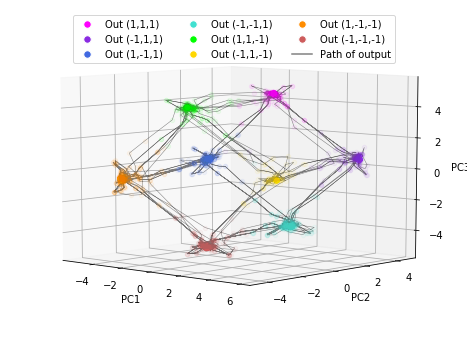

In [13]:
# Drawing of pca analysis

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

#
for i in range(3000):
    ax.scatter(s7d4_pc1[i], s7d4_pc2[i], s7d4_pc3[i], c=colors[s7d4_out_type[i]], alpha=0.05)

ax.plot(s7d4_pc1[:3000], s7d4_pc2[:3000], s7d4_pc3[:3000], '-k', linewidth=0.5, alpha=0.5)

custom_legend = [
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,1])], marker = '.', label = 'Out (1,1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,1,1])], marker = '.', label = 'Out (-1,1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,-1,1])], marker = '.', label = 'Out (1,-1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,-1,1])], marker = '.', label = 'Out (-1,-1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,-1])], marker = '.', label = 'Out (1,1,-1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,1,-1])], marker = '.', label = 'Out (-1,1,-1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,-1,-1])], marker = '.', label = 'Out (1,-1,-1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,-1,-1])], marker = '.', label = 'Out (-1,-1,-1)'),
    Line2D([0], [0], color = 'gray', label = 'Path of output')
]
ax.legend(handles = custom_legend, loc=9, ncol=3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(8,-48)

---
PCA analysis of test for delay of 4 time-steps.

---

Delay = 8

In [14]:
# Simple pca analysis of the test for random_seed=7 and time_delay=8

s7d8_pca = PCA(n_components=3)
s7d8_pca.fit(s7d8_states)
s7d8_pc1, s7d8_pc2, s7d8_pc3 = s7d8_pca.transform(s7d8_states).T

# Type of output for the neurons states
s7d8_out_type = np.array([tension_to_index(out) for out in s7d8_output])

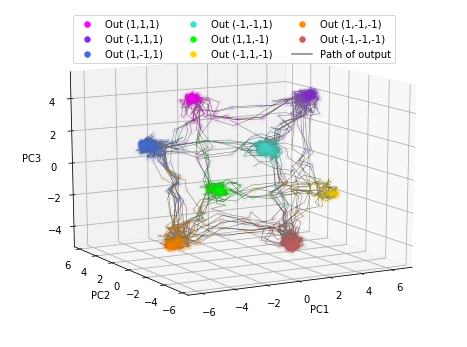

In [15]:
# Drawing of pca analysis

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Color coded points for neurons' states at each time step
for i in range(3000):
    ax.scatter(s7d8_pc1[i], s7d8_pc2[i], s7d8_pc3[i], c=colors[s7d8_out_type[i]], alpha=0.05)
# Path over time of neurons' states
ax.plot(s7d8_pc1[:3000], s7d8_pc2[:3000], s7d8_pc3[:3000], '-k', linewidth=0.5, alpha=0.5)

custom_legend = [
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,1])], marker = '.', label = 'Out (1,1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,1,1])], marker = '.', label = 'Out (-1,1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,-1,1])], marker = '.', label = 'Out (1,-1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,-1,1])], marker = '.', label = 'Out (-1,-1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,-1])], marker = '.', label = 'Out (1,1,-1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,1,-1])], marker = '.', label = 'Out (-1,1,-1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,-1,-1])], marker = '.', label = 'Out (1,-1,-1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([-1,-1,-1])], marker = '.', label = 'Out (-1,-1,-1)'),
    Line2D([0], [0], color = 'gray', label = 'Path of output')
]
ax.legend(handles = custom_legend, loc=9, ncol=3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(14,-119)

---
PCA analysis of test for delay of 8 time-steps.

---

# Slow point analysis

0 delay

In [16]:
# Calculating approximate cube
s7d0_center_array = []
for i in range(8):
    indexes = np.where(np.equal(s7d0_out_type,i*np.ones(len(s7d0_out_type))))[0]
    s7d0_center= np.mean(s7d0_states[indexes],axis=0)
    s7d0_center_array.append(s7d0_center)
s7d0_center_array = np.array(s7d0_center_array)

s7d0_cube = s7d0_center_array[switch]

In [17]:
# Finding slow points
s7d0_min_q = []
for i in range(300):
    opt_result = scipy.optimize.minimize(q,(np.random.rand(nb_neurons)-0.5)*10,args=(s7d0_w))
    # if {optimization was a success} and ( {this is the first slow point} or {slow point does not correspond to one already found} )
    if opt_result['success'] and (len(s7d0_min_q)==0 or np.all([np.linalg.norm(np.abs(min_q_i-opt_result['x']))>1 for min_q_i in s7d0_min_q])):
        s7d0_min_q.append(opt_result['x'])
s7d0_min_q = np.array(s7d0_min_q)

# Calculating the number of free dimensions for each slow point
s7d0_q_type = []
for min_q_i in s7d0_min_q:
    J = np.empty((nb_neurons,nb_neurons))
    for i in range(nb_neurons):
        J[i,:] = np.dot(s7d0_w[i,:],(1/np.cosh(min_q_i[i]))**2)-I[i,:]
    s7d0_q_type.append(sum(np.linalg.eig(J)[0]>0))

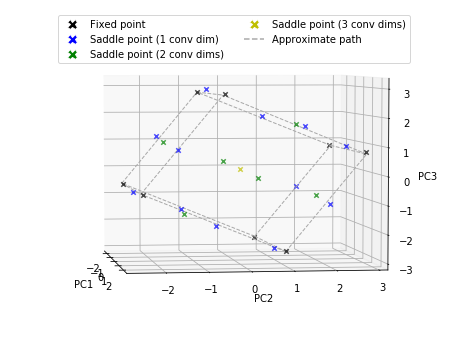

In [38]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for edge in s7d0_cube:
    edge_pc1, edge_pc2, edge_pc3 = s7d0_pca.transform(edge).T
    ax.plot(edge_pc1, edge_pc2, edge_pc3, '--', c='darkgray', lw=1)

min_q_pc1, min_q_pc2, min_q_pc3 = s7d0_pca.transform(s7d0_min_q).T
for i in range(s7d0_min_q.shape[0]):
    if(s7d0_q_type[i]<=3):
        ax.scatter(min_q_pc1[i], min_q_pc2[i], min_q_pc3[i], c=['k','b','g','y'][s7d0_q_type[i]], marker='x', alpha=0.7)
    else:
        ax.scatter(min_q_pc1[0,i], min_q_pc2[1,i], min_q_pc3[2,i], c='r', marker='^', alpha=0.7)
        ax.text(min_q_pc1[i], min_q_pc2[i], min_q_pc3[i], str(s7d0_q_type[i]))

custom_legend = [
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'k', marker = 'X', label = 'Fixed point'),
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'b', marker = 'X', label = 'Saddle point (1 conv dim)'),
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'g', marker = 'X', label = 'Saddle point (2 conv dims)'),
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'y', marker = 'X', label = 'Saddle point (3 conv dims)'),
    Line2D([0], [0], color = 'darkgray', linestyle='--', label = 'Approximate path')
]
ax.legend(handles = custom_legend, loc=9, ncol=2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(4,-8)

---
Slow point analysis of RNN without delay. For clarity, a cube is used to mark the approximate path of neurons states during the test. The slow points are color coded with respect to the number of convex dimensions.

---

4 delay

In [19]:
# Calculating approximate cube
s7d4_center_array = []
for i in range(8):
    indexes = np.where(np.equal(s7d4_out_type,i*np.ones(len(s7d4_out_type))))[0]
    s7d4_center= np.mean(s7d4_states[indexes],axis=0)
    s7d4_center_array.append(s7d4_center)
s7d4_center_array = np.array(s7d4_center_array)

s7d4_cube = s7d4_center_array[switch]

In [20]:
# Finding slow points
s7d4_min_q = []
for i in range(300):
    opt_result = scipy.optimize.minimize(q,(np.random.rand(nb_neurons)-0.5)*10,args=(s7d4_w))
    # if {optimization was a success} and ( {this is the first slow point} or {slow point does not correspond to one already found} )
    if opt_result['success'] and (len(s7d4_min_q)==0 or np.all([np.linalg.norm(np.abs(min_q_i-opt_result['x']))>1 for min_q_i in s7d4_min_q])):
        s7d4_min_q.append(opt_result['x'])
s7d4_min_q = np.array(s7d4_min_q)

# Calculating the number of free dimensions for each slow point
s7d4_q_type = []
for min_q_i in s7d4_min_q:
    J = np.empty((nb_neurons,nb_neurons))
    for i in range(nb_neurons):
        J[i,:] = np.dot(s7d4_w[i,:],(1/np.cosh(min_q_i[i]))**2)-I[i,:]
    s7d4_q_type.append(sum(np.linalg.eig(J)[0]>0))

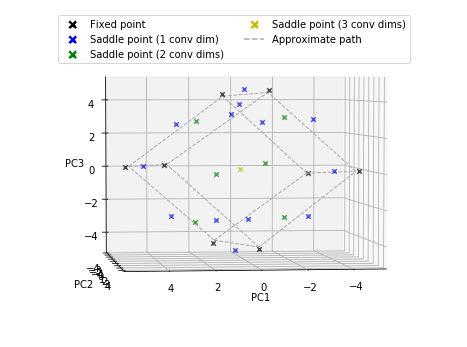

In [39]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for edge in s7d4_cube:
    edge_pc1, edge_pc2, edge_pc3 = s7d4_pca.transform(edge).T
    ax.plot(edge_pc1, edge_pc2, edge_pc3, '--', c='darkgray', lw=1)

min_q_pc1, min_q_pc2, min_q_pc3 = s7d4_pca.transform(s7d4_min_q).T
for i in range(s7d4_min_q.shape[0]):
    if(s7d4_q_type[i]<=3):
        ax.scatter(min_q_pc1[i], min_q_pc2[i], min_q_pc3[i], c=['k','b','g','y'][s7d4_q_type[i]], marker='x', alpha=0.7)
    else:
        ax.scatter(min_q_pc1[i], min_q_pc2[i], min_q_pc3[i], c='r', marker='^', alpha=0.7)
        ax.text(min_q_pc1[i], min_q_pc2[i], min_q_pc3[i], str(s7d4_q_type[i]))

custom_legend = [
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'k', marker = 'X', label = 'Fixed point'),
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'b', marker = 'X', label = 'Saddle point (1 conv dim)'),
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'g', marker = 'X', label = 'Saddle point (2 conv dims)'),
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'y', marker = 'X', label = 'Saddle point (3 conv dims)'),
    Line2D([0], [0], color = 'darkgray', linestyle='--', label = 'Approximate path')
]
ax.legend(handles = custom_legend, loc=9, ncol=2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(3,83)

---
Slow point analysis of RNN with 4 time steps delay

---

8 delay

In [22]:
# Calculating approximate cube
s7d8_center_array = []
for i in range(8):
    indexes = np.where(np.equal(s7d8_out_type,i*np.ones(len(s7d8_out_type))))[0]
    s7d8_center= np.mean(s7d8_states[indexes],axis=0)
    s7d8_center_array.append(s7d8_center)
s7d8_center_array = np.array(s7d8_center_array)

s7d8_cube = s7d8_center_array[switch]

In [23]:
# Finding slow points
s7d8_min_q = []
for i in range(500):
    opt_result = scipy.optimize.minimize(q,(np.random.rand(nb_neurons)-0.5)*10,args=(s7d8_w))
    # if {optimization was a success} and ( {this is the first slow point} or {slow point does not correspond to one already found} )
    if opt_result['success'] and (len(s7d8_min_q)==0 or np.all([np.linalg.norm(np.abs(min_q_i-opt_result['x']))>0.2 for min_q_i in s7d8_min_q])):
        s7d8_min_q.append(opt_result['x'])
s7d8_min_q = np.array(s7d8_min_q)

# Calculating the number of free dimensions for each slow point
s7d8_q_type = []
for min_q_i in s7d8_min_q:
    J = np.empty((nb_neurons,nb_neurons))
    for i in range(nb_neurons):
        J[i,:] = np.dot(s7d8_w[i,:],(1/np.cosh(min_q_i[i]))**2)-I[i,:]
    s7d8_q_type.append(sum(np.linalg.eig(J)[0]>0))

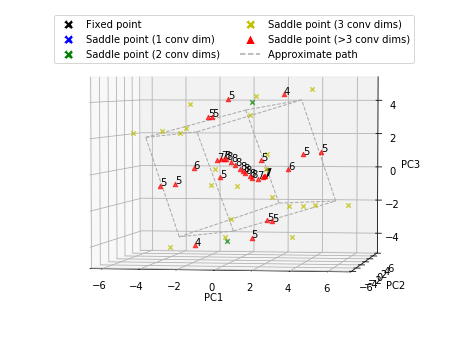

In [40]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for edge in s7d8_cube:
    edge_pc1, edge_pc2, edge_pc3 = s7d8_pca.transform(edge).T
    ax.plot(edge_pc1, edge_pc2, edge_pc3, '--', c='darkgray', lw=1)

min_q_pc1, min_q_pc2, min_q_pc3 = s7d8_pca.transform(s7d8_min_q).T
for i in range(s7d8_min_q.shape[0]):
    if(s7d8_q_type[i]<=3):
        ax.scatter(min_q_pc1[i], min_q_pc2[i], min_q_pc3[i], c=['k','b','g','y'][s7d8_q_type[i]], marker='x', alpha=0.7)
    else:
        ax.scatter(min_q_pc1[i], min_q_pc2[i], min_q_pc3[i], c='r', marker='^', alpha=0.7)
        ax.text(min_q_pc1[i], min_q_pc2[i], min_q_pc3[i], str(s7d8_q_type[i]))

custom_legend = [
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'k', marker = 'X', label = 'Fixed point'),
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'b', marker = 'X', label = 'Saddle point (1 conv dim)'),
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'g', marker = 'X', label = 'Saddle point (2 conv dims)'),
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'y', marker = 'X', label = 'Saddle point (3 conv dims)'),
    Line2D([0], [0], color = 'w', markersize = 10, markerfacecolor = 'r', marker = '^', label = 'Saddle point (>3 conv dims)'),
    Line2D([0], [0], color = 'darkgray', linestyle='--', label = 'Approximate path')
]
ax.legend(handles = custom_legend, loc=9, ncol=2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(3,-81)

---
Slow point analysis of RNN with 8 time steps delay. There are now slow points with more than three convex dimensions. Those are marked by red triangles and the number of convex dimensions written above.

---

# Triggered average analysis

0 delay

In [25]:
time_delay = 0
nb_before = time_delay+10
nb_after = 11
pattern = np.concatenate((np.ones(nb_before)*tension_to_index([1,1,1]),np.ones(nb_after)*tension_to_index([1,1,-1]))).astype('int')
triggered_indexes = matchPattern(s7d0_out_type,pattern)
triggered_indexes = np.array([np.arange(i,i+nb_before+nb_after) for i in triggered_indexes])
s7d0_triggered_states = np.mean(s7d0_states[triggered_indexes],axis=0)

In [26]:
s7d0_triggered_pca = PCA(3)
s7d0_triggered_pca.fit(s7d0_triggered_states[8:-9])
s7d0_trig_pc1, s7d0_trig_pc2, s7d0_trig_pc3 = s7d0_triggered_pca.transform(s7d0_triggered_states).T

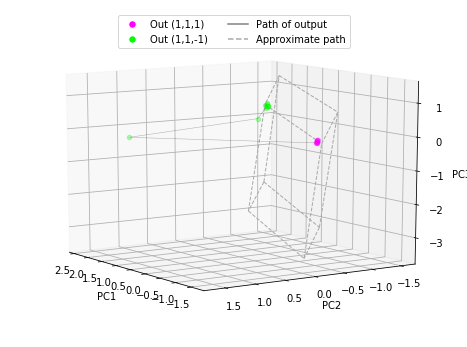

In [27]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for edge in s7d0_cube:
    edge_pc1, edge_pc2, edge_pc3 = s7d0_triggered_pca.transform(edge).T
    ax.plot(edge_pc1, edge_pc2, edge_pc3, '--', c='darkgray', lw=1)

for i in range(len(pattern)):
    ax.scatter(s7d0_trig_pc1[i], s7d0_trig_pc2[i], s7d0_trig_pc3[i], c=colors[pattern[i]], alpha=0.3)
ax.plot(s7d0_trig_pc1, s7d0_trig_pc2, s7d0_trig_pc3, '-k', linewidth=0.5, alpha=0.3)

custom_legend = [
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,1])], marker = '.', label = 'Out (1,1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,-1])], marker = '.', label = 'Out (1,1,-1)'),
    Line2D([0], [0], color = 'gray', label = 'Path of output'),
    Line2D([0], [0], color = 'darkgray', linestyle='--', label = 'Approximate path')
]
ax.legend(handles = custom_legend, loc=9, ncol=2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(11,146)

---
The switch from output (1,1,1) to output (1,1,-1) for the RNN without delay was studied using a triggered average. Here is the PCA analysis of the transition state. A few points before and after the switch are also plotted to show the relative movement of the transition to that of the two quasi-stable states.

---

4 delay

In [28]:
time_delay = 4
nb_before = time_delay+10
nb_after = 11
pattern = np.concatenate((np.ones(nb_before)*tension_to_index([1,1,1]),np.ones(nb_after)*tension_to_index([1,1,-1]))).astype('int')
triggered_indexes = matchPattern(s7d4_out_type,pattern)
triggered_indexes = np.array([np.arange(i,i+nb_before+nb_after) for i in triggered_indexes])
s7d4_triggered_states = np.mean(s7d4_states[triggered_indexes],axis=0)

In [29]:
s7d4_triggered_pca = PCA(3)
s7d4_triggered_pca.fit(s7d4_triggered_states[9:-10])
s7d4_trig_pc1, s7d4_trig_pc2, s7d4_trig_pc3 = s7d4_triggered_pca.transform(s7d4_triggered_states).T

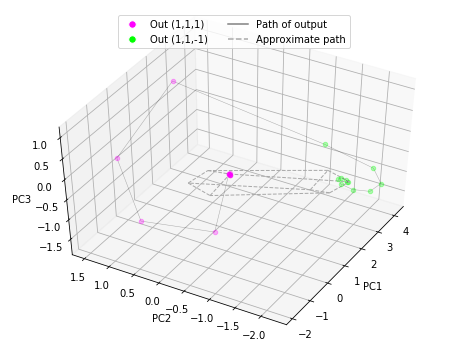

In [30]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for edge in s7d4_cube:
    edge_pc1, edge_pc2, edge_pc3 = s7d4_triggered_pca.transform(edge).T
    ax.plot(edge_pc1, edge_pc2, edge_pc3, '--', c='darkgray', lw=1)

for i in range(len(pattern)):
    ax.scatter(s7d4_trig_pc1[i], s7d4_trig_pc2[i], s7d4_trig_pc3[i], c=colors[pattern[i]], alpha=0.3)
ax.plot(s7d4_trig_pc1, s7d4_trig_pc2, s7d4_trig_pc3, '-k', linewidth=0.5, alpha=0.3)

custom_legend = [
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,1])], marker = '.', label = 'Out (1,1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,-1])], marker = '.', label = 'Out (1,1,-1)'),
    Line2D([0], [0], color = 'gray', label = 'Path of output'),
    Line2D([0], [0], color = 'darkgray', linestyle='--', label = 'Approximate path')
]
ax.legend(handles = custom_legend, loc=9, ncol=2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(46,-150)

---
The switch from output (1,1,1) to output (1,1,-1) for the RNN with 4 time steps delay.

---

8 delay

In [31]:
time_delay = 8
nb_before = time_delay+10
nb_after = 11
pattern = np.concatenate((np.ones(nb_before)*tension_to_index([1,1,1]),np.ones(nb_after)*tension_to_index([1,1,-1]))).astype('int')
triggered_indexes = matchPattern(s7d8_out_type,pattern)
triggered_indexes = np.array([np.arange(i,i+nb_before+nb_after) for i in triggered_indexes])
s7d8_triggered_states = np.mean(s7d8_states[triggered_indexes],axis=0)

In [32]:
s7d8_triggered_pca = PCA(3)
s7d8_triggered_pca.fit(s7d8_triggered_states[9:-10])
s7d8_trig_pc1, s7d8_trig_pc2, s7d8_trig_pc3 = s7d8_triggered_pca.transform(s7d8_triggered_states).T

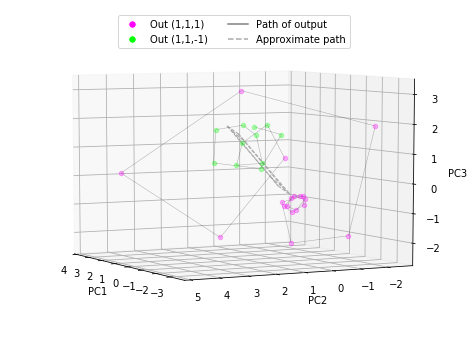

In [33]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for edge in s7d8_cube:
    edge_pc1, edge_pc2, edge_pc3 = s7d8_triggered_pca.transform(edge).T
    ax.plot(edge_pc1, edge_pc2, edge_pc3, '--', c='darkgray', lw=1)

for i in range(len(pattern)):
    ax.scatter(s7d8_trig_pc1[i], s7d8_trig_pc2[i], s7d8_trig_pc3[i], c=colors[pattern[i]], alpha=0.3)
ax.plot(s7d8_trig_pc1, s7d8_trig_pc2, s7d8_trig_pc3, '-k', linewidth=0.5, alpha=0.3)

custom_legend = [
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,1])], marker = '.', label = 'Out (1,1,1)'),
    Line2D([0], [0], color = 'w', markersize = 15, markerfacecolor = colors[tension_to_index([1,1,-1])], marker = '.', label = 'Out (1,1,-1)'),
    Line2D([0], [0], color = 'gray', label = 'Path of output'),
    Line2D([0], [0], color = 'darkgray', linestyle='--', label = 'Approximate path')
]
ax.legend(handles = custom_legend, loc=9, ncol=2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(6,152)

---
The switch from output (1,1,1) to output (1,1,-1) for the RNN with 8 time steps delay.

---

# Eigenvalues analysis

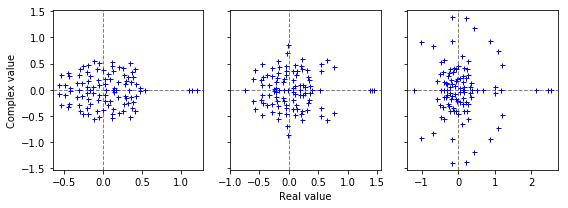

In [34]:
s7d0_eigvals = np.linalg.eig(s7d0_w)[0]
s7d4_eigvals = np.linalg.eig(s7d4_w)[0]
s7d8_eigvals = np.linalg.eig(s7d8_w)[0]

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, sharey=True, figsize=(8,3))

ax0.axvline(0,linestyle='--',color='gray',linewidth=1)
ax0.axhline(0,linestyle='--',color='gray',linewidth=1)
ax0.plot(s7d0_eigvals.real,s7d0_eigvals.imag,'b+',ms=5)
ax0.set_xticks([-0.5,0,0.5,1])

ax1.axvline(0,linestyle='--',color='gray',linewidth=1)
ax1.axhline(0,linestyle='--',color='gray',linewidth=1)
ax1.plot(s7d4_eigvals.real,s7d4_eigvals.imag,'b+',ms=5)
ax1.set_xticks([-1,-0.5,0,0.5,1,1.5])

ax2.axvline(0,linestyle='--',color='gray',linewidth=1)
ax2.axhline(0,linestyle='--',color='gray',linewidth=1)
ax2.plot(s7d8_eigvals.real,s7d8_eigvals.imag,'b+',ms=5)
ax2.set_xticks([-1,0,1,2])

ax0.set_ylabel('Complex value')
ax1.set_xlabel('Real value')

fig.tight_layout()

---
Analysis of the eigenvalues for the three studied RNNs. The eigenvalues of the network without delay is diplayed to the left, the ones of the network with 4 time steps delay to the center and the ones of the network with 8 time steps delay to the right.

---